<a href="https://colab.research.google.com/github/Vishal-2603/Company_Project/blob/main/Yolo_11_Task_Company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# How to Train YOLO11 Object Detection on a Custom Dataset

---

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
from google.colab import userdata
api = userdata.get('ROBOFLOW_API_KEY')

In [ ]:
!nvidia-smi

Tue Nov 25 11:01:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.3/112.6 GB disk)


## Inference with model pre-trained on custom dataset

**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

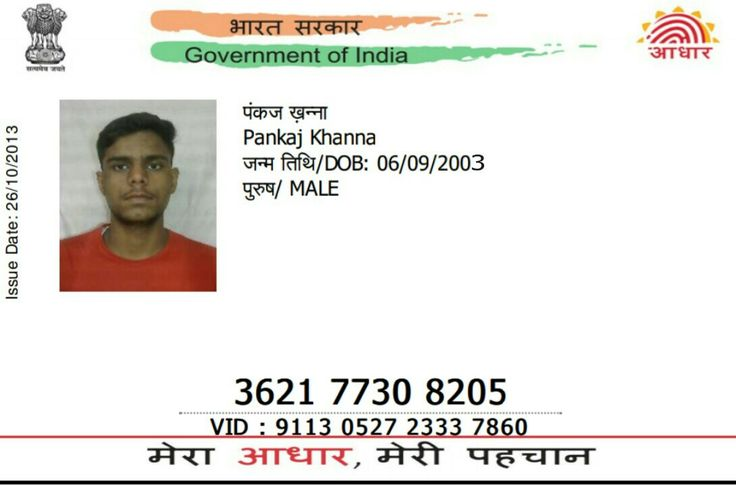

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/1348191a4d1dda185edd1c6ee32436f0.jpg', width=600)

# Load Model

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open('/content/1348191a4d1dda185edd1c6ee32436f0.jpg')
result = model.predict(image, conf=0.25)[0]


0: 448x640 1 person, 49.3ms
Speed: 6.9ms preprocess, 49.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[ 60.0030, 110.1177, 216.4736, 290.1141]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.8884], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([0.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
detections

Detections(xyxy=array([[     60.003,      110.12,      216.47,      290.11]], dtype=float32), mask=None, confidence=array([    0.88842], dtype=float32), class_id=array([0]), tracker_id=None, data={'class_name': array(['person'], dtype='<U6')}, metadata={})

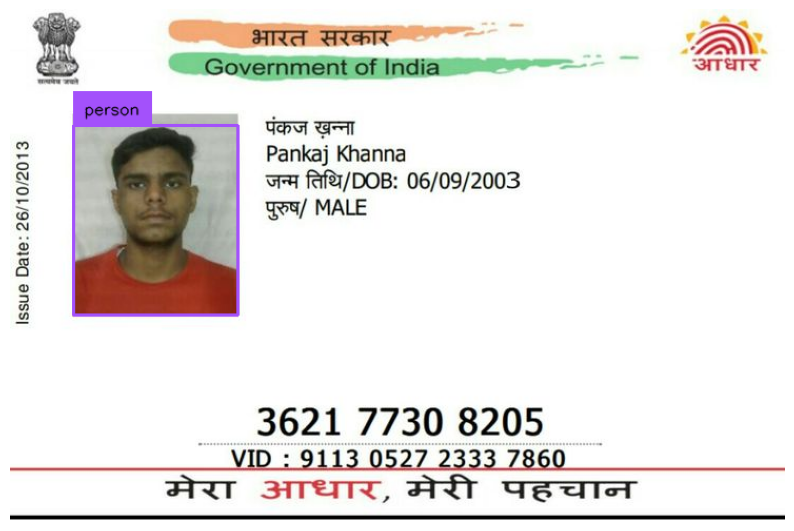

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

# On Known Image

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open('/content/1348191a4d1dda185edd1c6ee32436f0.jpg')
result = model.predict(image, conf=0.25)[0]


0: 448x640 1 person, 19.3ms
Speed: 4.2ms preprocess, 19.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
result.boxes.xyxy

tensor([[ 60.0030, 110.1177, 216.4736, 290.1141]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.8884], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([0.], device='cuda:0')

In [ ]:
detections = sv.Detections.from_ultralytics(result)
detections

Detections(xyxy=array([[     60.003,      110.12,      216.47,      290.11]], dtype=float32), mask=None, confidence=array([    0.88842], dtype=float32), class_id=array([0]), tracker_id=None, data={'class_name': array(['person'], dtype='<U6')}, metadata={})

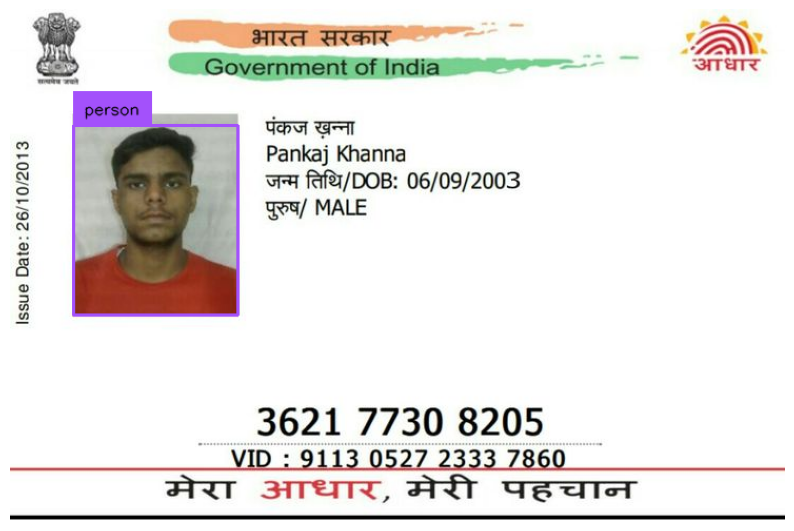

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

In [ ]:
#https://app.roboflow.com/vishal-pagere-tfuqz/id-card-8apvj-rebqm/1

SyntaxError: invalid decimal literal (ipython-input-2043641650.py, line 1)

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("vishal-pagere-tfuqz").project("id-card-8apvj-rebqm")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ID-card-1 in yolov11:: 100%|██████████| 2352/2352 [00:00<00:00, 7190.42it/s]


## Custom Training

In [ ]:
dataset.location

'/content/datasets/ID-card-1'

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/ID-card-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg		val_batch0_pred.jpg
BoxF1_curve.png			 results.csv		val_batch1_labels.jpg
BoxP_curve.png			 results.png		val_batch1_pred.jpg
BoxPR_curve.png			 train_batch0.jpg	val_batch2_labels.jpg
BoxR_curve.png			 train_batch1.jpg	val_batch2_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	weights
confusion_matrix.png		 val_batch0_labels.jpg


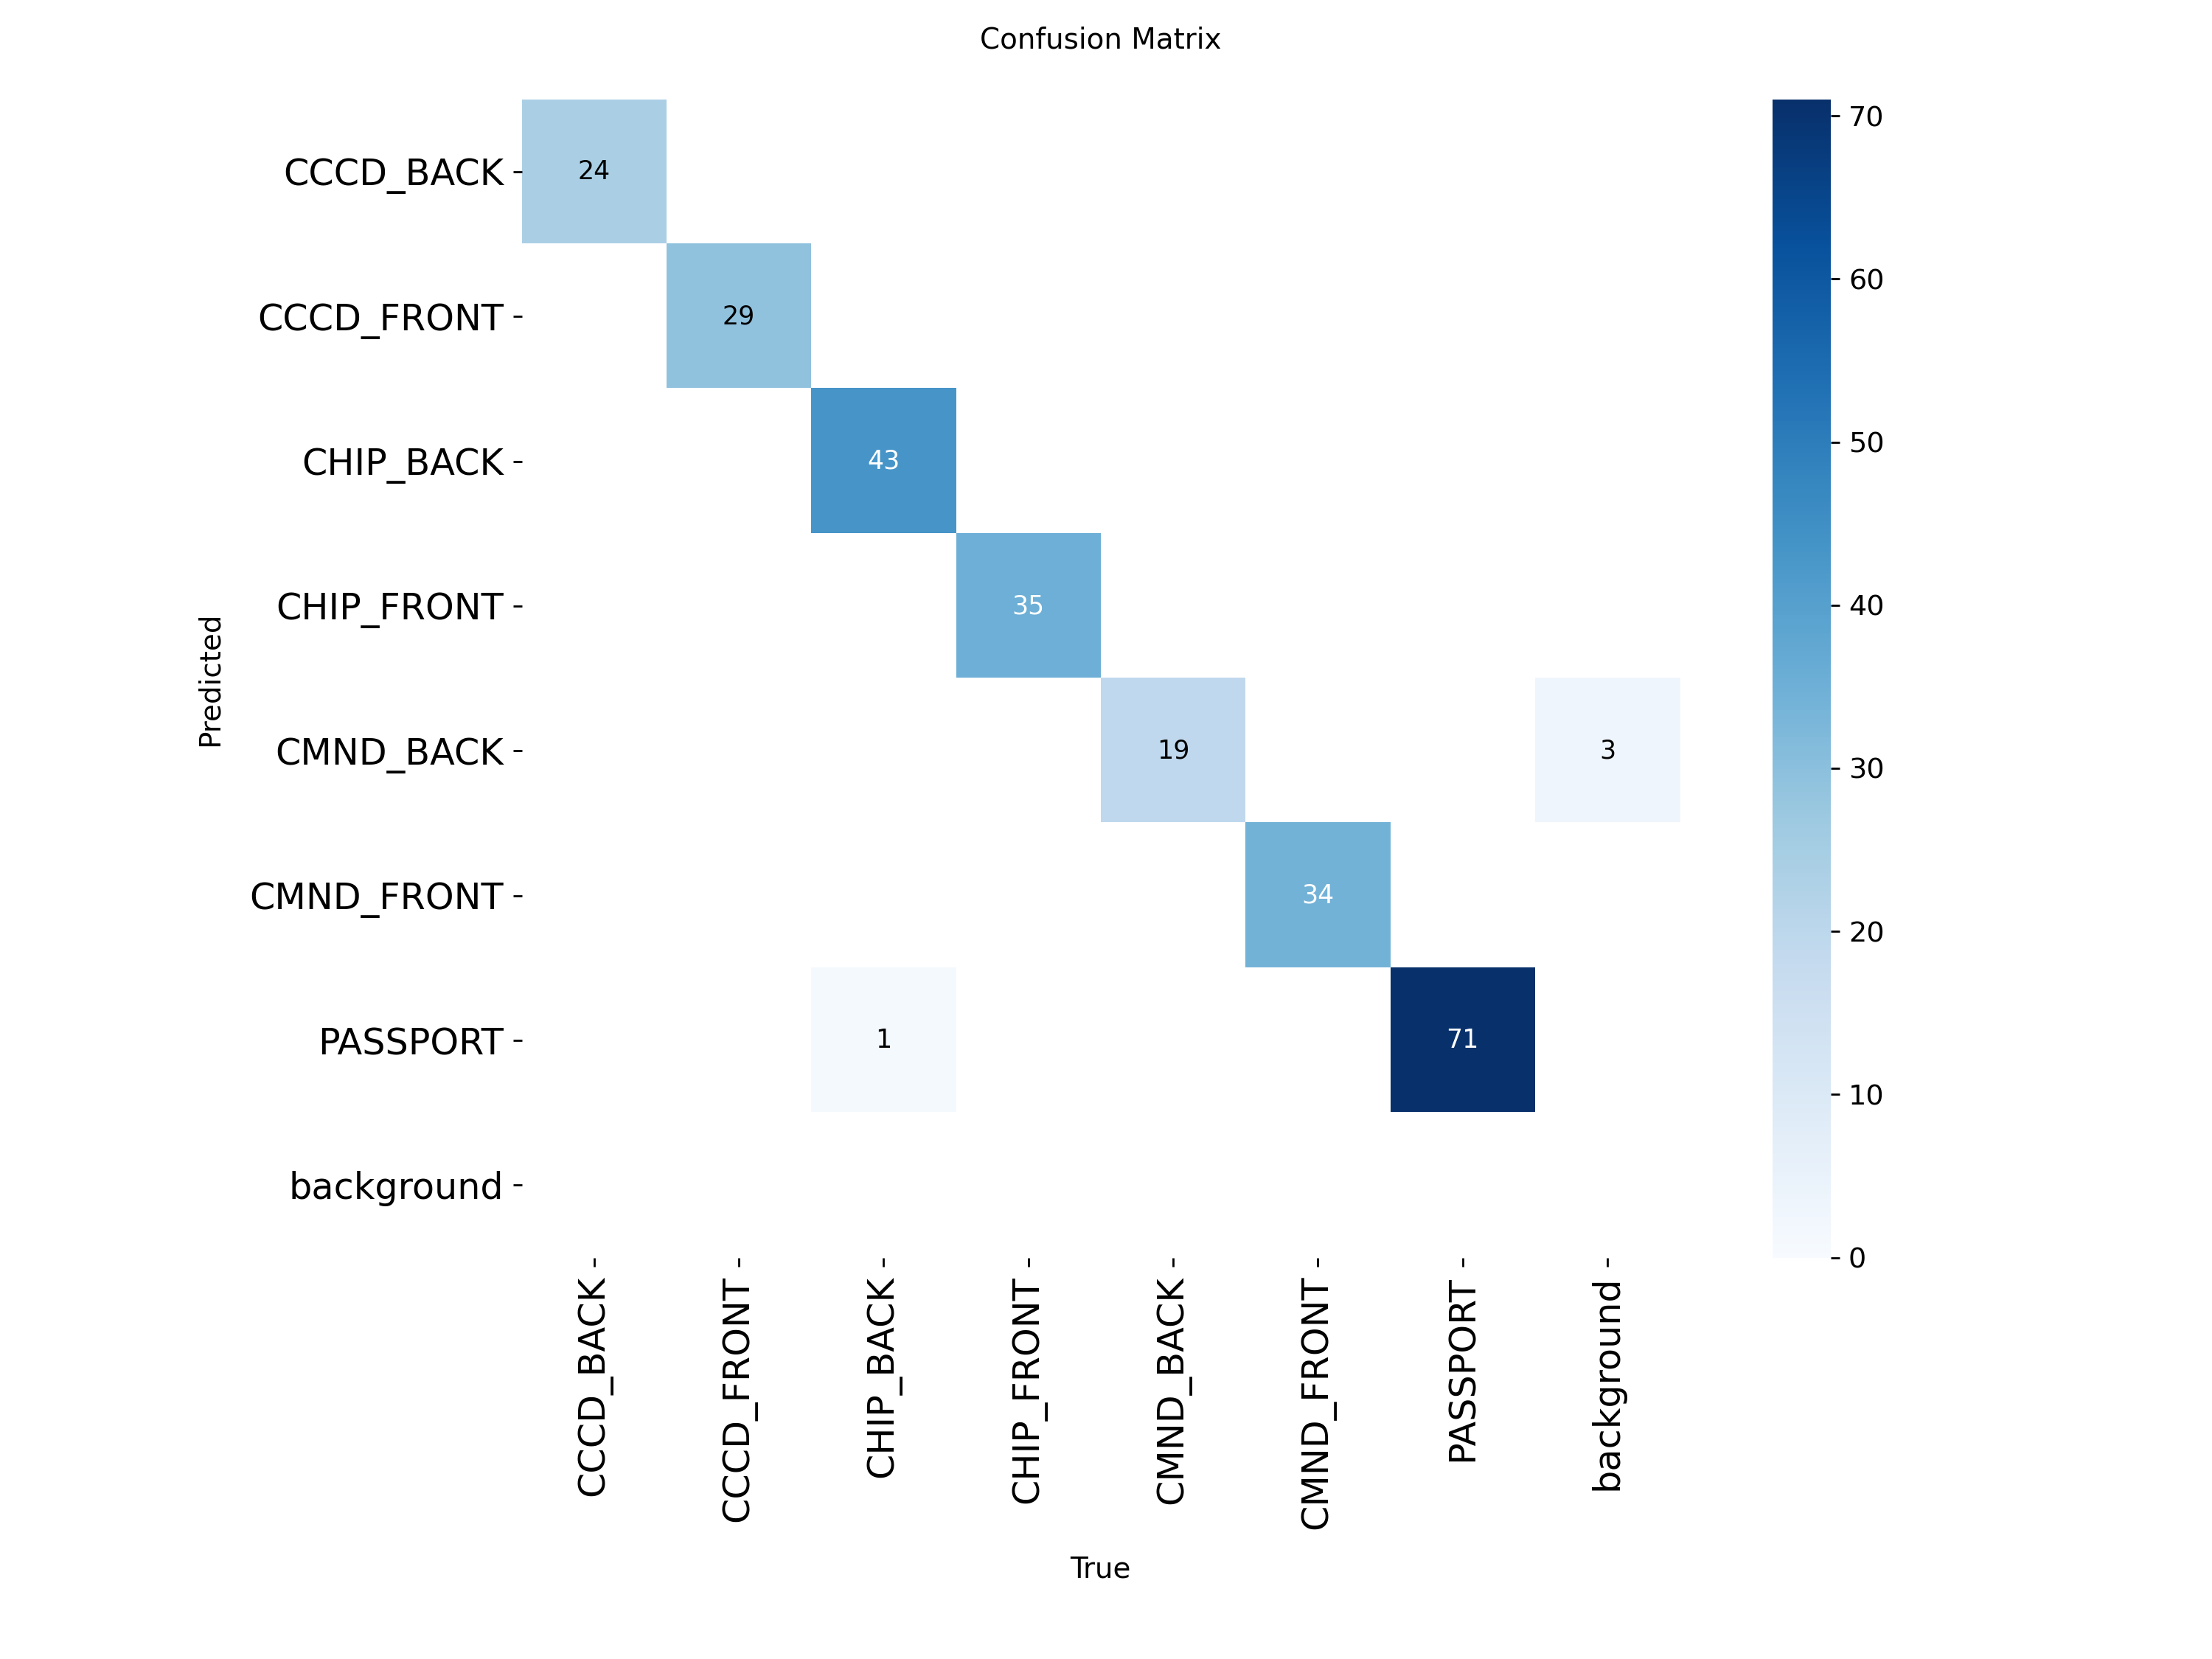

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

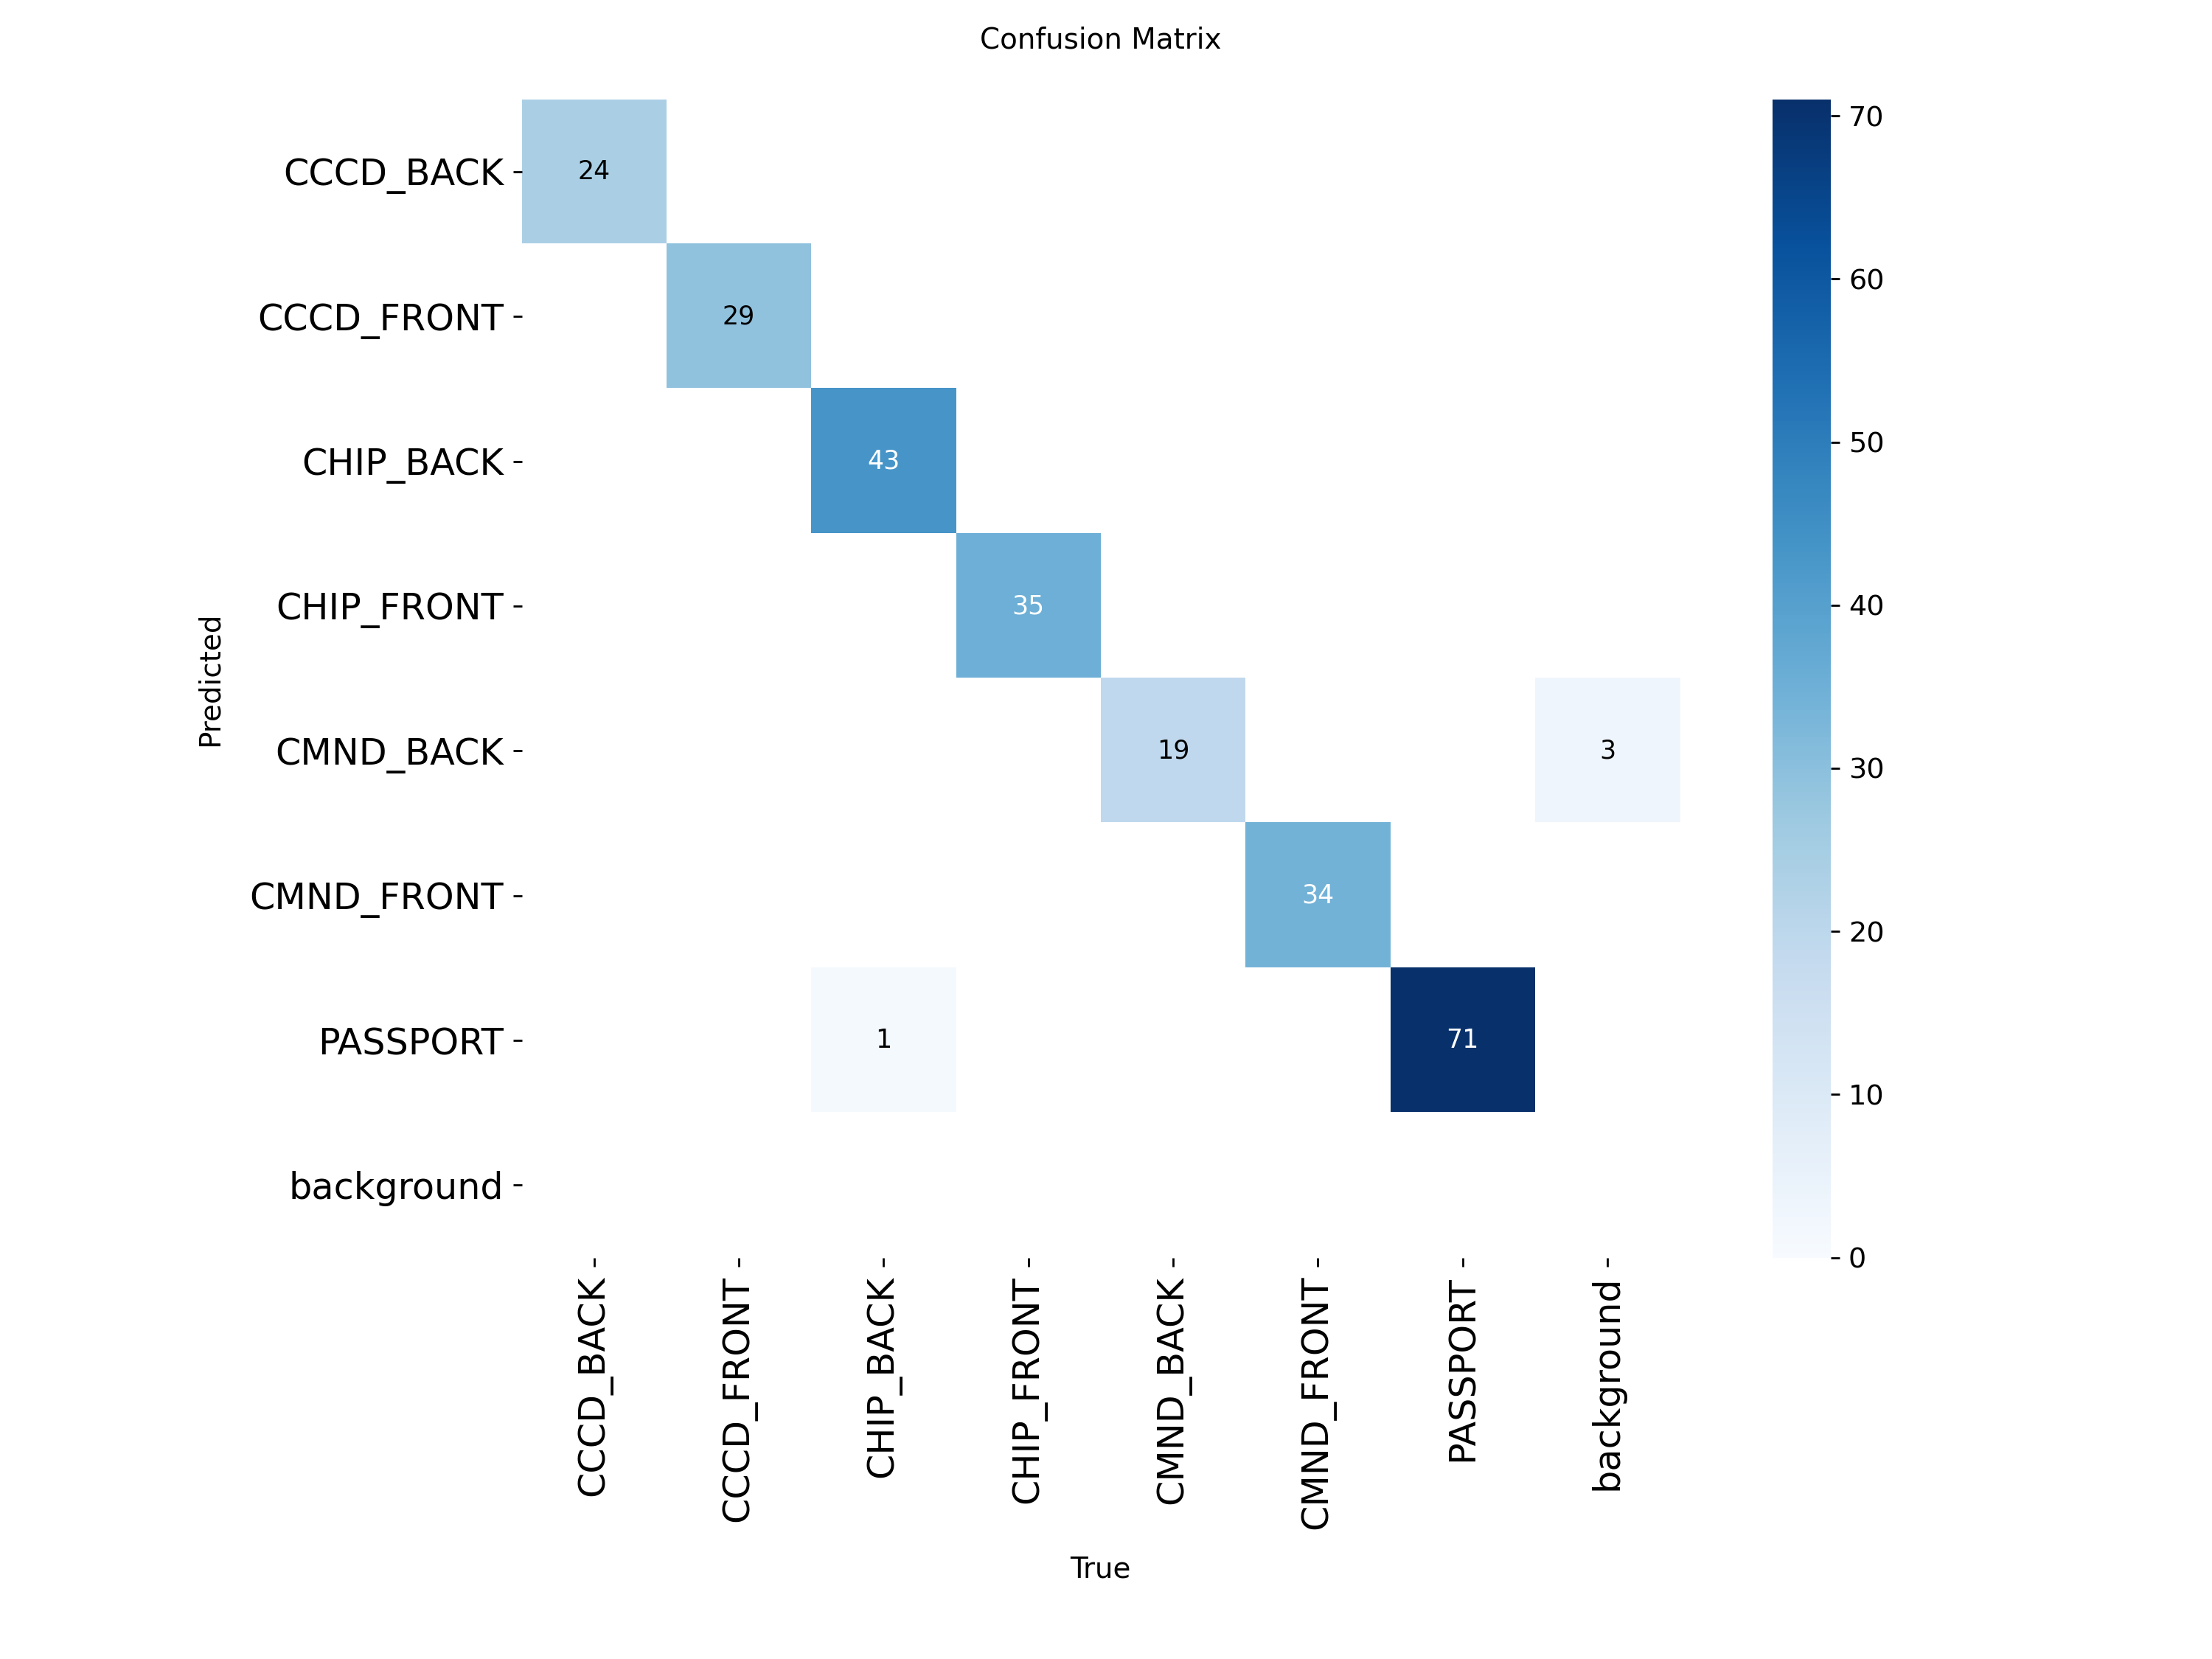

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

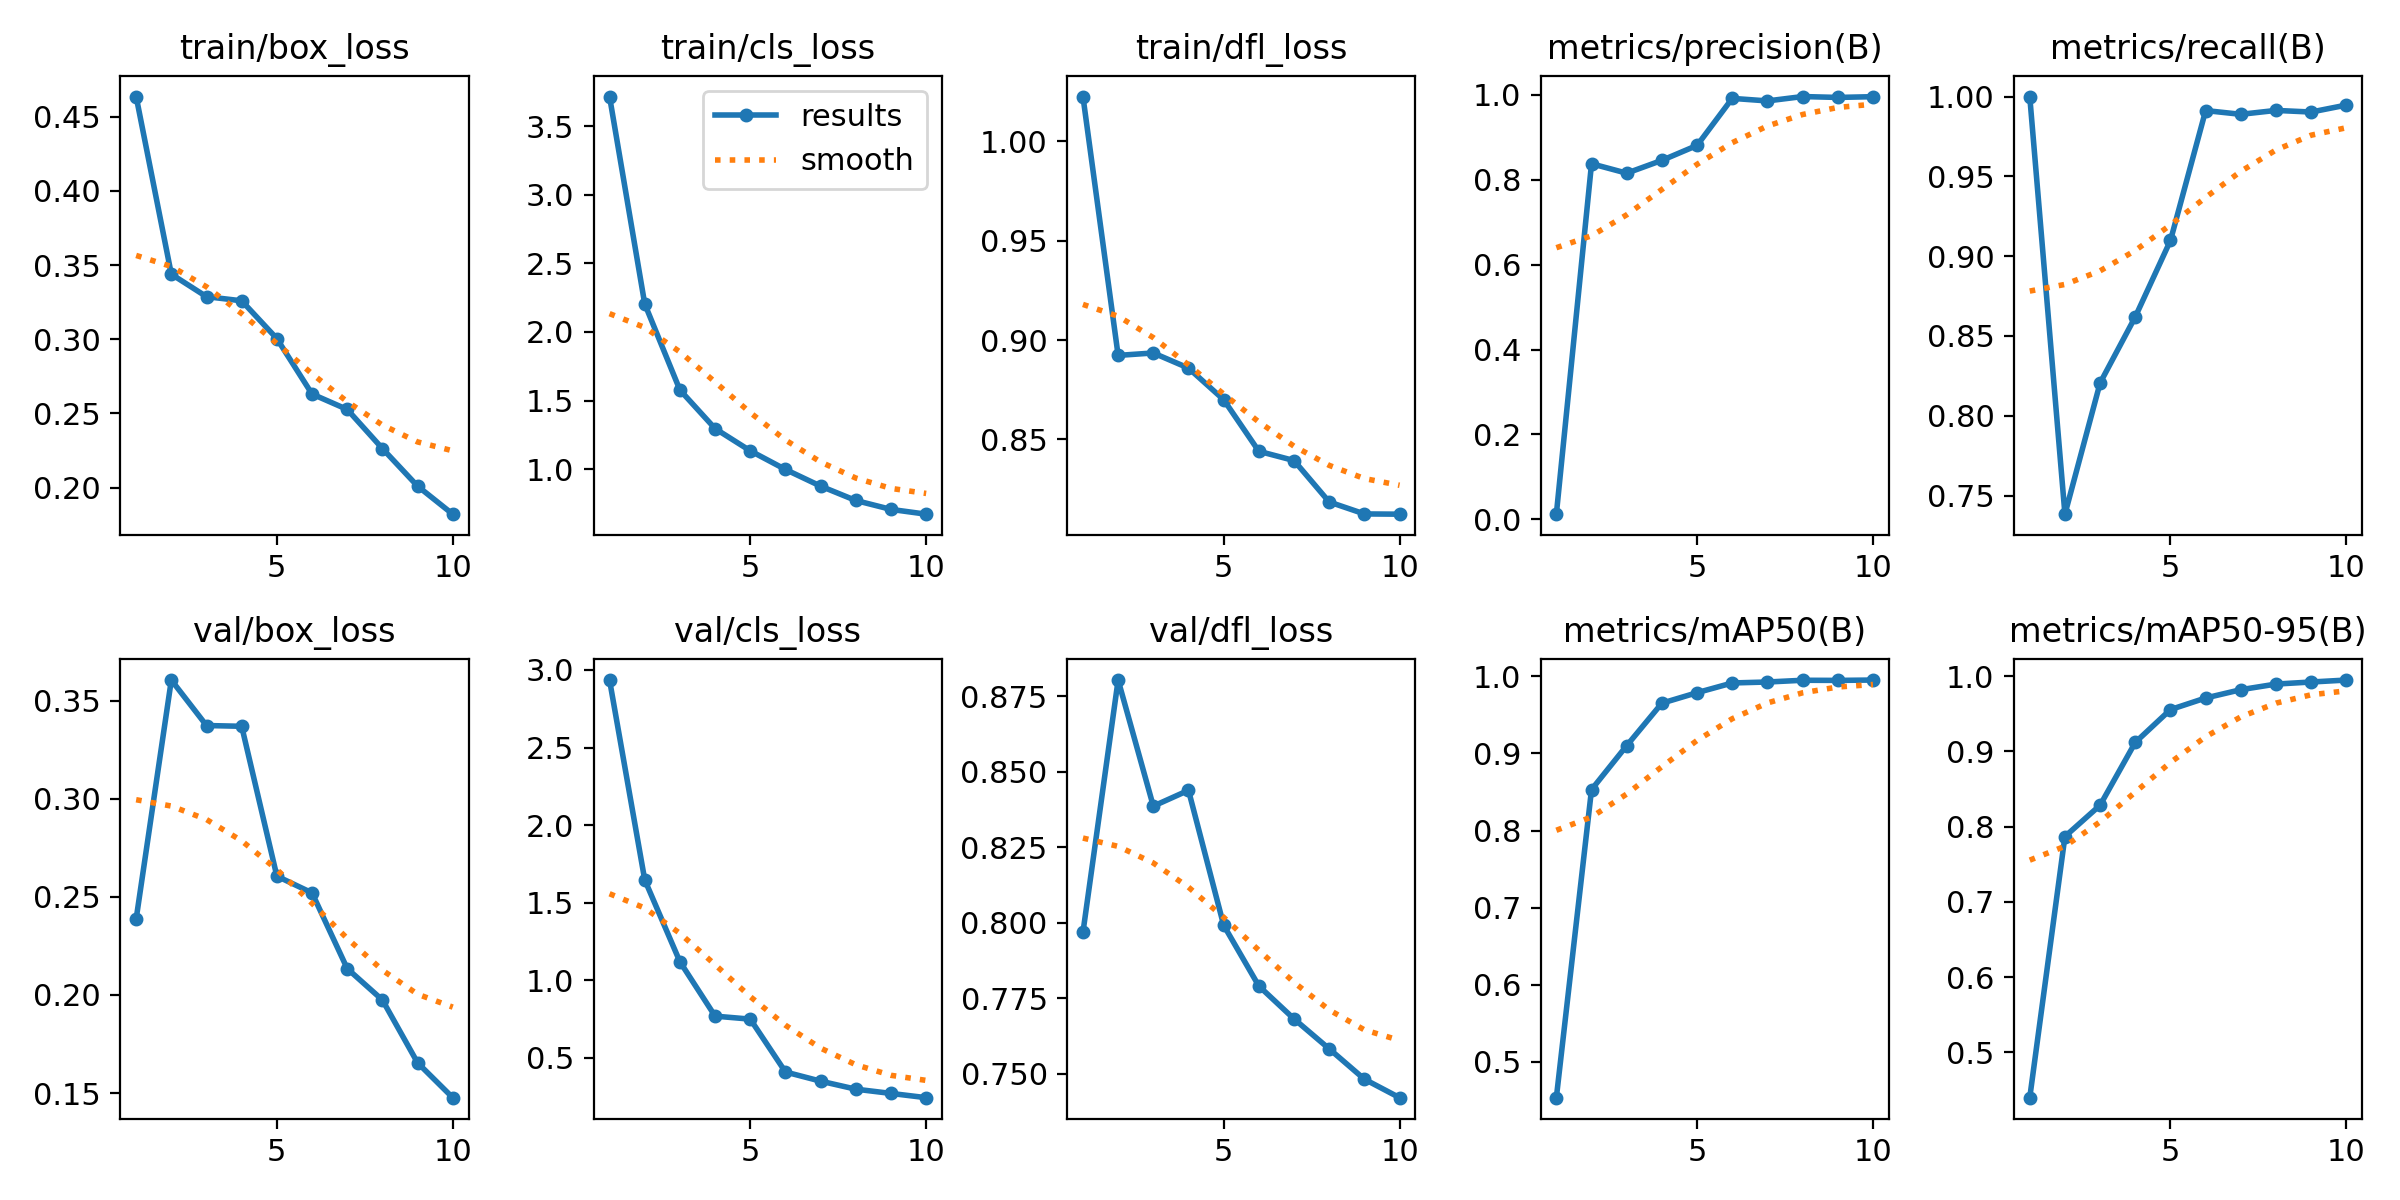

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

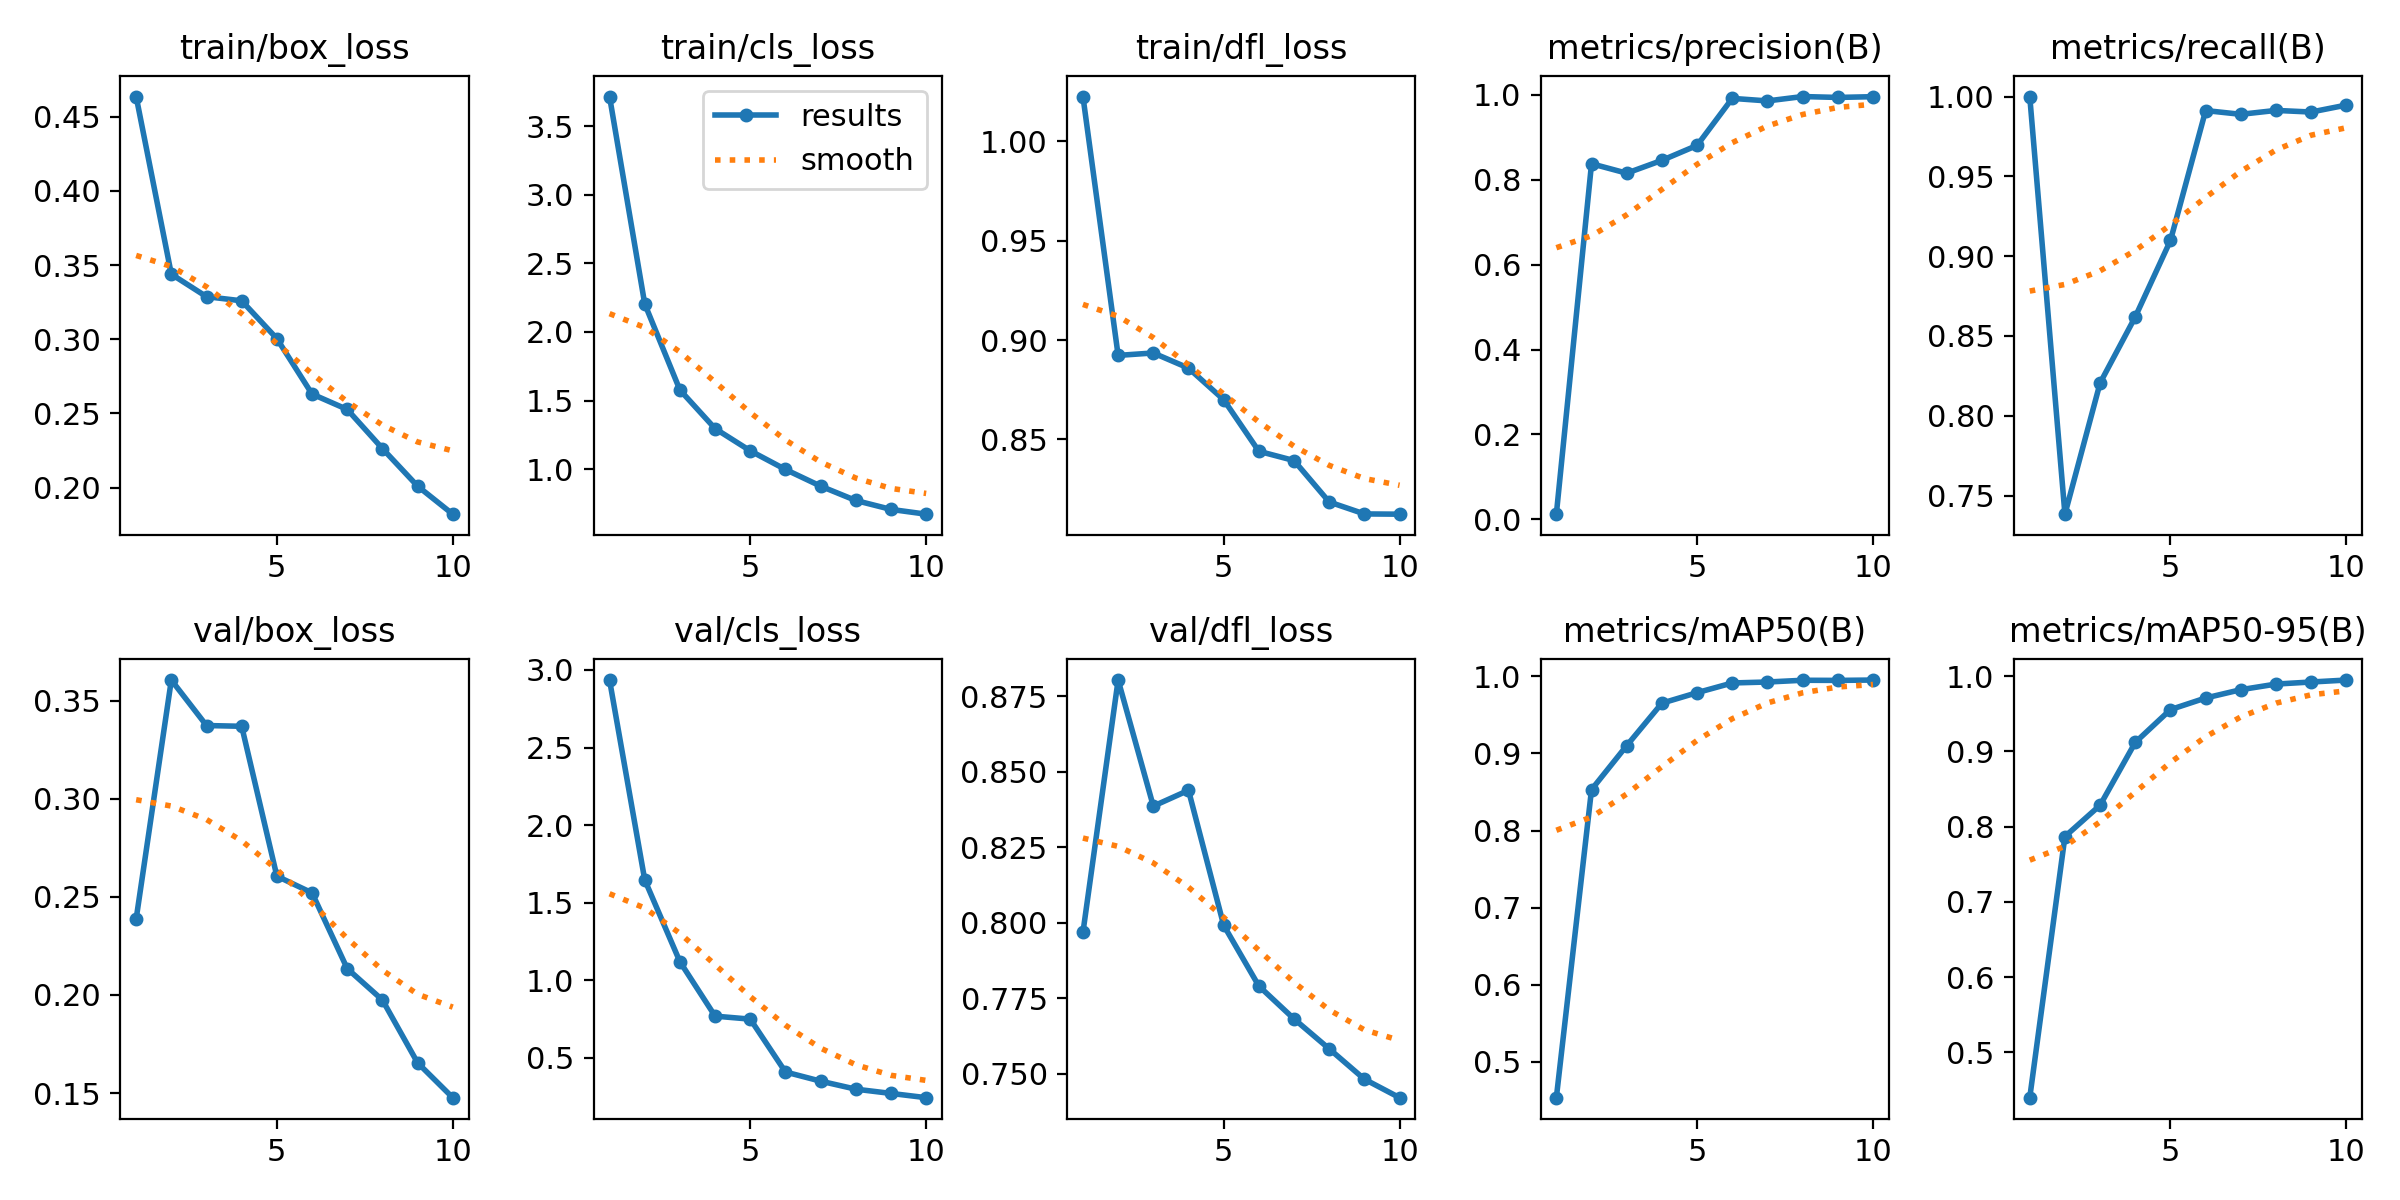

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

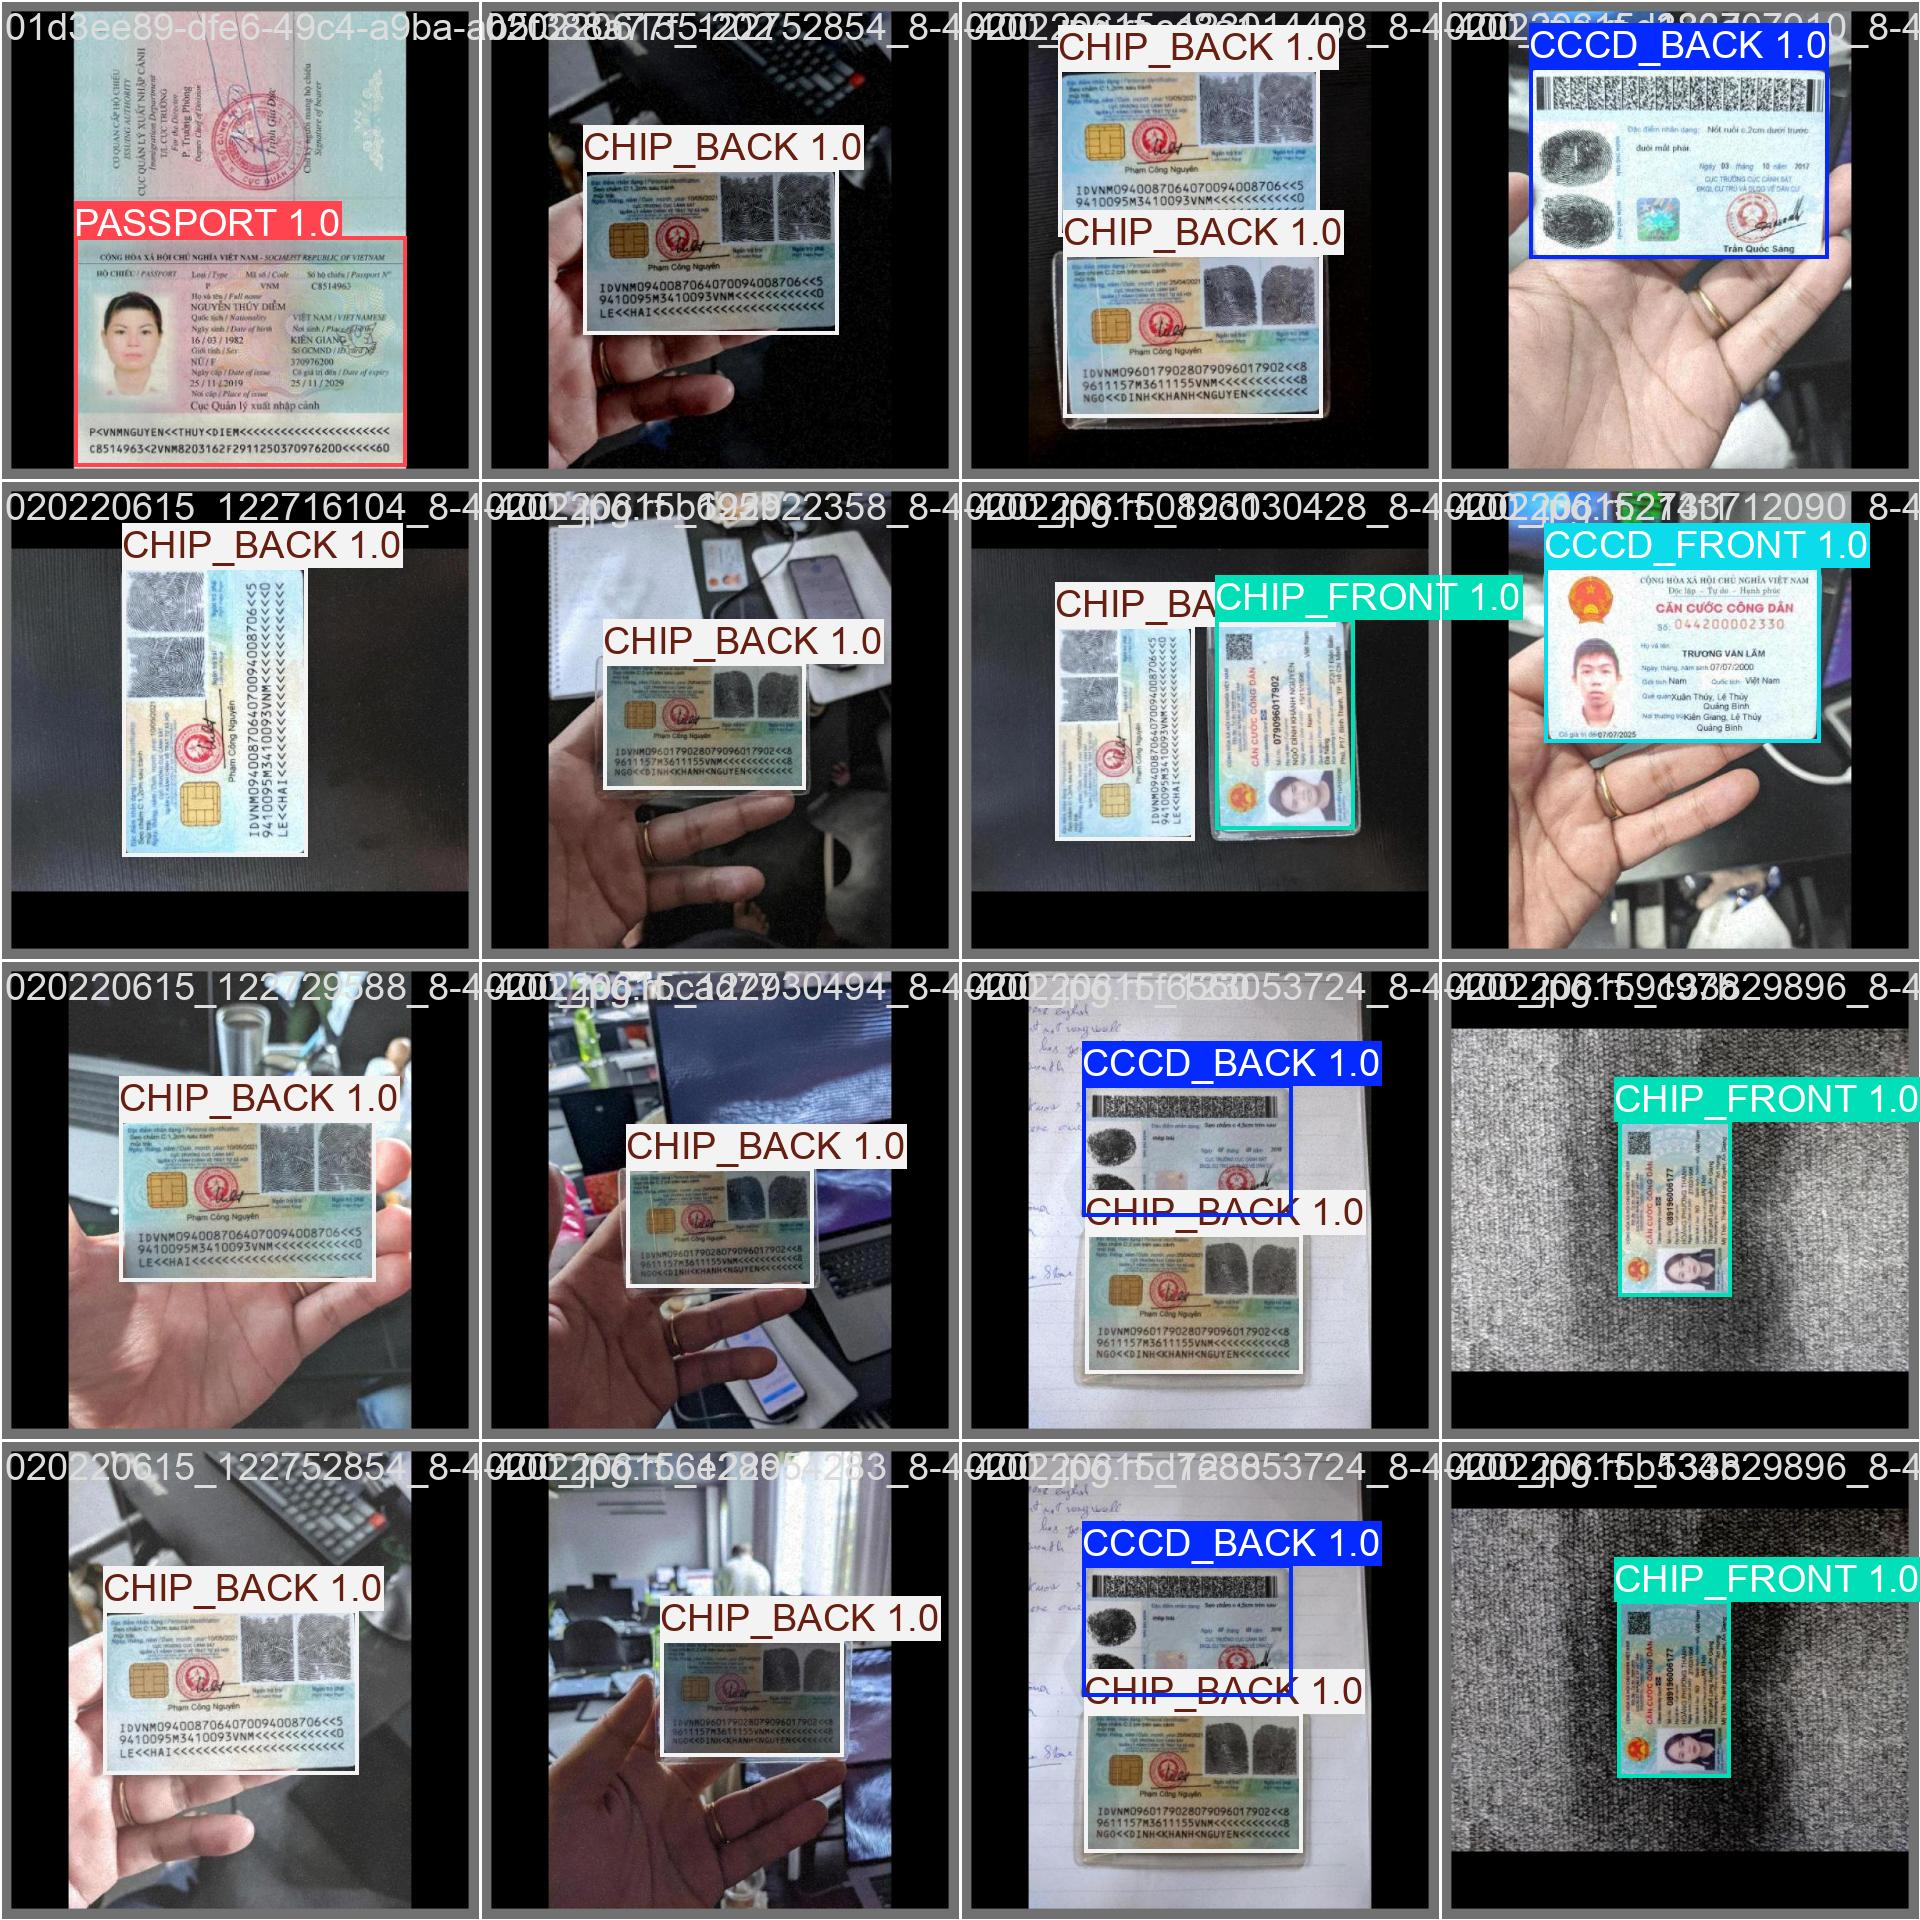

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=640)

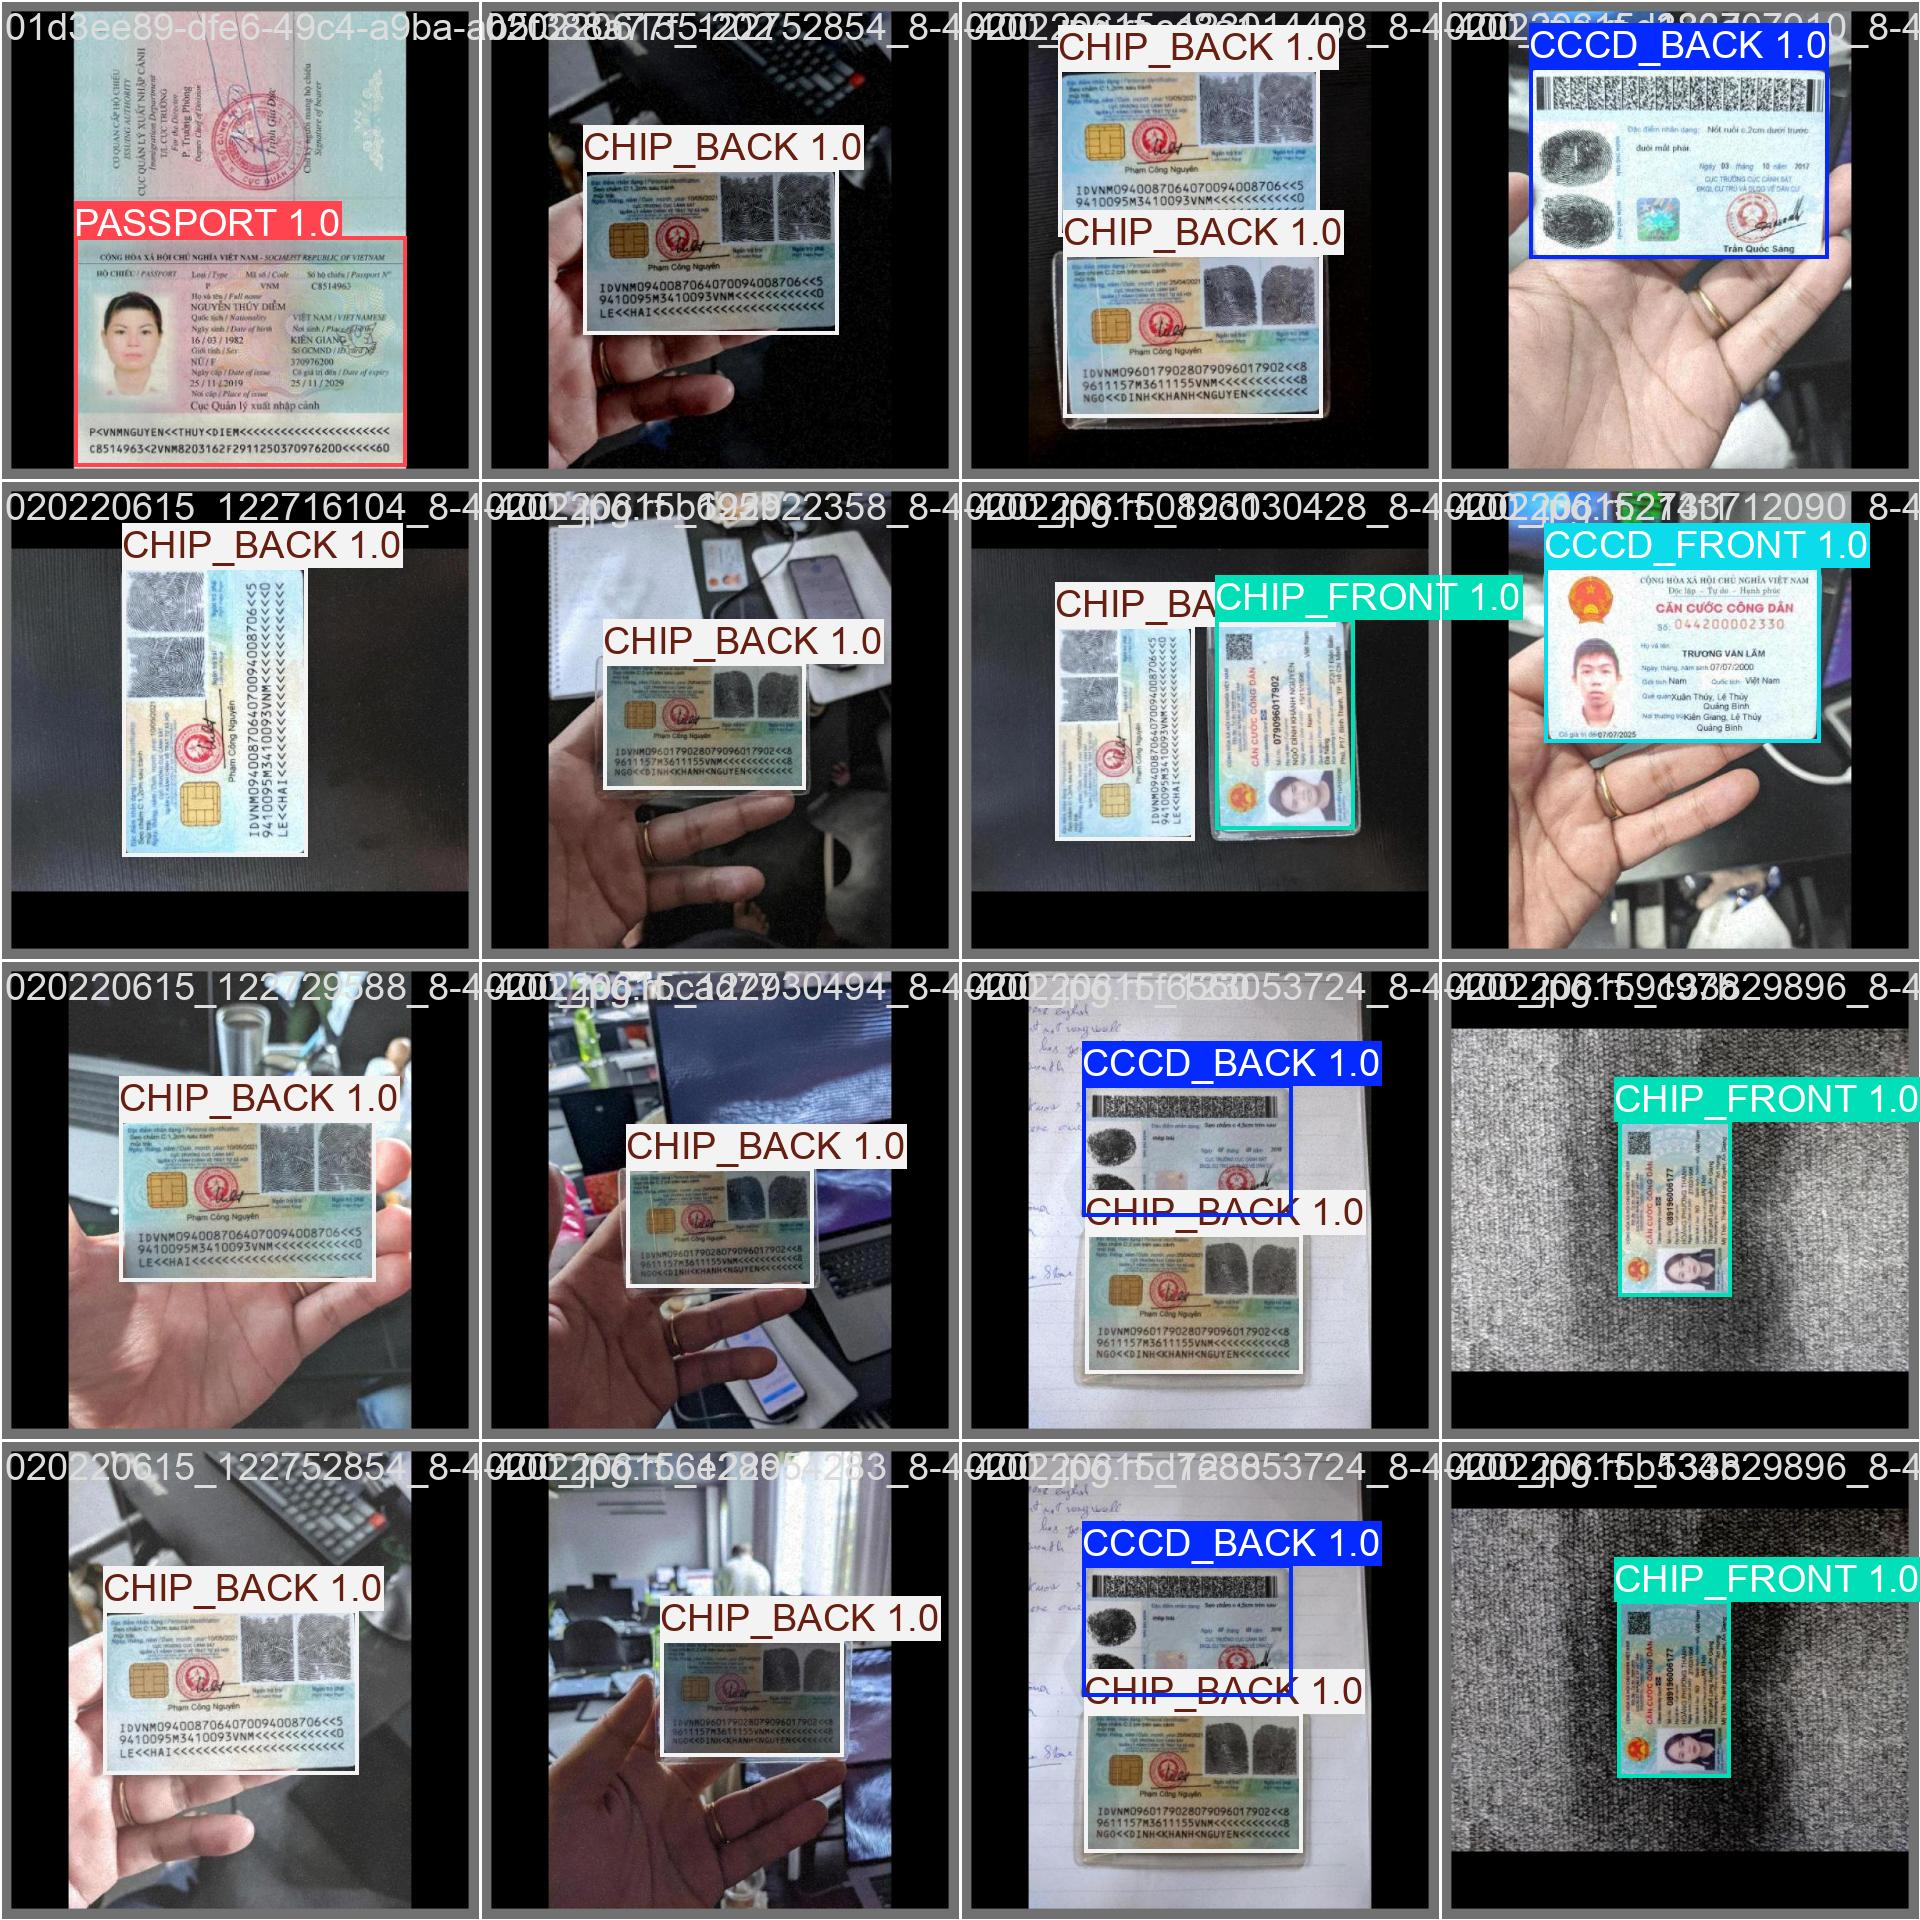

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=640)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1352.7±283.1 MB/s, size: 45.3 KB)
val: Scanning /content/datasets/ID-card-1/valid/labels.cache... 234 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 234/234 3.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 4.4it/s 3.4s
                   all        234        256      0.996      0.995      0.995      0.995
             CCCD_BACK         24         24      0.996          1      0.995      0.995
            CCCD_FRONT         29         29      0.998          1      0.995      0.995
             CHIP_BACK         43         44          1      0.963      0.995      0.995
            CHIP_FRONT         35         35      0.998          1      0.995      0.995
             CMND_BACK         19   

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.50 source={dataset.location}/test/images save=True

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs

image 1/118 /content/datasets/ID-card-1/test/images/020220615_122729588_8-4-400_jpg.rf.6f3f8af54e4d93cc0ede15309b885f68.jpg: 640x640 1 CHIP_BACK, 11.9ms
image 2/118 /content/datasets/ID-card-1/test/images/020220615_122815017_8-4-400_jpg.rf.79472af34327f520a1938cab160d6aef.jpg: 640x640 1 CHIP_BACK, 8.0ms
image 3/118 /content/datasets/ID-card-1/test/images/020220615_122942895_8-4-400_jpg.rf.2fe1571deae44c025b51fd9404ba61a0.jpg: 640x640 1 CHIP_BACK, 7.9ms
image 4/118 /content/datasets/ID-card-1/test/images/020220615_122942895_8-4-400_jpg.rf.c1b0c0a81ce638815795c4e563e4a0bc.jpg: 640x640 1 CHIP_BACK, 9.9ms
image 5/118 /content/datasets/ID-card-1/test/images/020220615_122954283_8-4-400_jpg.rf.ad0e611898bbbd39c55d26d74fd11fd7.jpg: 640x640 1 CHIP_BACK, 7.9ms
image 6/118 /content/datasets/ID-card-1/test/images/020220615_123014498_

**NOTE:** Let's take a look at few results.

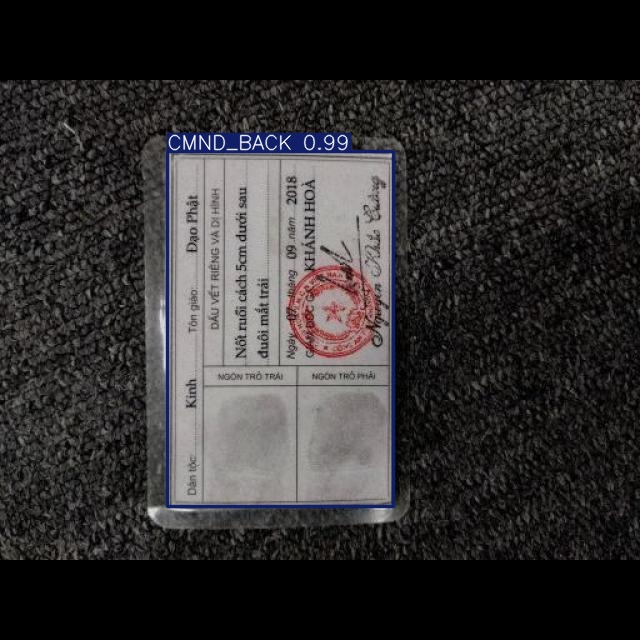

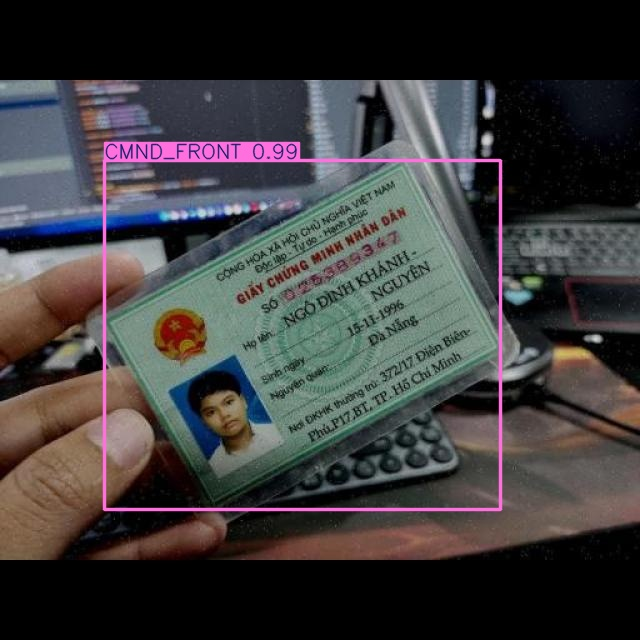

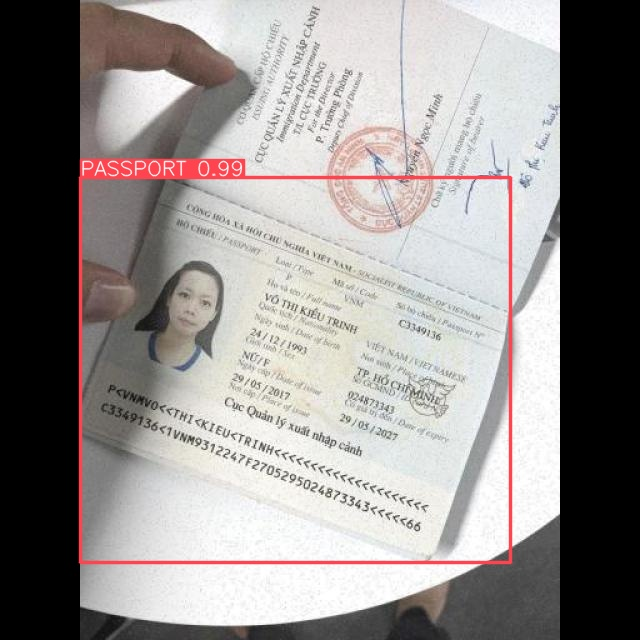

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

# Load the model in new variable

In [ ]:
from ultralytics import YOLO

# Load the custom model
model_loaded = YOLO('/content/runs/detect/train/weights/best.pt')

# Inference

Running inference on 1654682804533_JPEG_jpg.rf.7030d107fcbb3ade54b798e490e4cf8e.jpg

0: 640x640 1 CHIP_FRONT, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


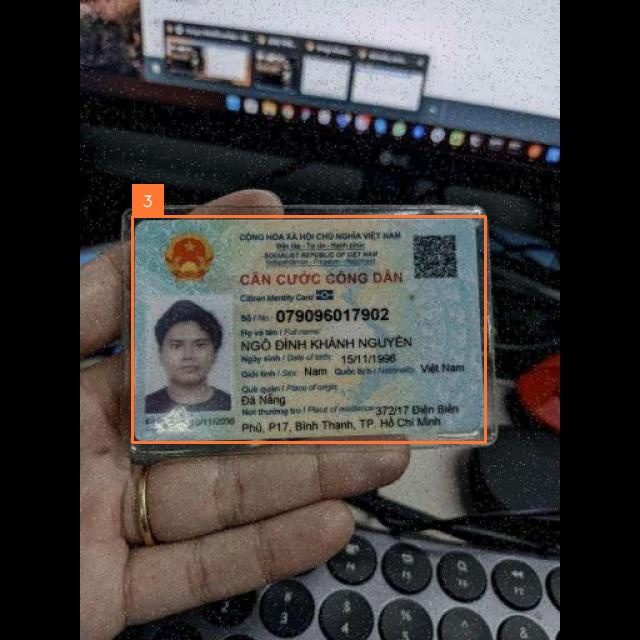

Running inference on 1654682538614_JPEG_jpg.rf.2e0f4a1a65234e45de6d69cdf74c8206.jpg

0: 640x640 1 CHIP_FRONT, 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


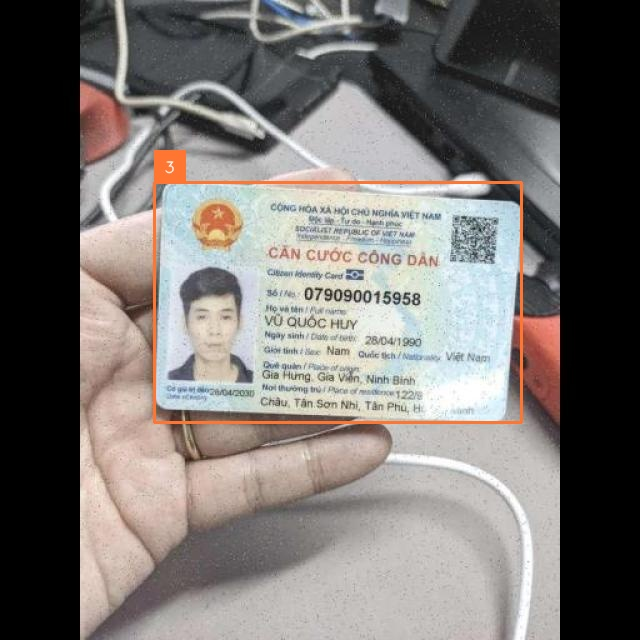

Running inference on 1659112904-2048466_jpg.rf.2567a5bf3b68f6abc382661daa419955.jpg

0: 640x640 1 CHIP_BACK, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


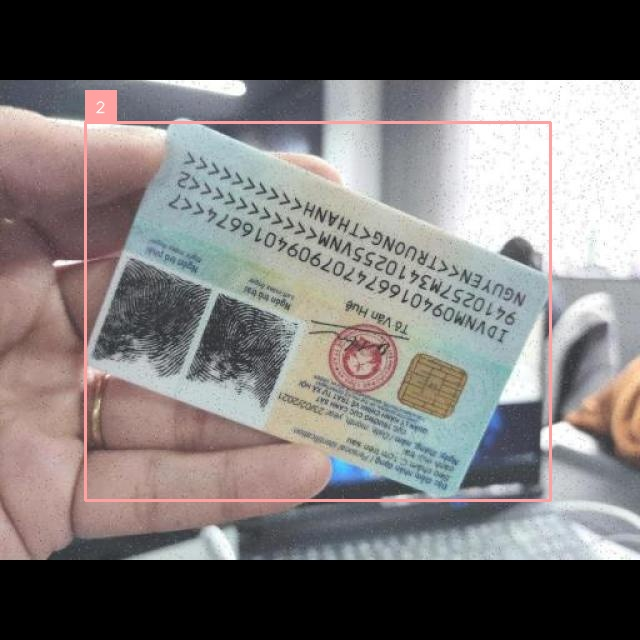

Running inference on IMG_20220614_140826_jpg.rf.d3512d98d98d7d91a353652458625376.jpg

0: 640x640 1 PASSPORT, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


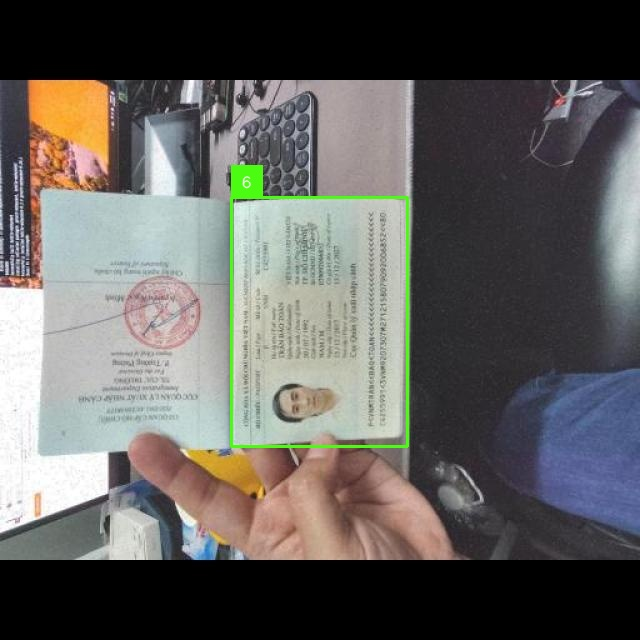

In [ ]:
import os
import random
import cv2
import supervision as sv
import IPython
from ultralytics import YOLO

# Load the custom model
model_loaded = YOLO('/content/runs/detect/train/weights/best.pt')

# Assuming 'dataset' is defined earlier with a 'location' attribute
# If not, replace this with the actual path to your test images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image_path = os.path.join(test_set_loc, img_name)
    image = cv2.imread(image_path)

    # Perform inference (note: method changed from .infer() to .predict())
    results = model_loaded(image, conf=0.4)[0]  # Confidence threshold set to 0.4

    # Convert results to Supervision Detections
    detections = sv.Detections(
        xyxy=results.boxes.xyxy.cpu().numpy(),
        confidence=results.boxes.conf.cpu().numpy(),
        class_id=results.boxes.cls.cpu().numpy().astype(int)
    )

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, buffer = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=buffer)
    IPython.display.display(i)

# Inference on single image


0: 480x640 1 CMND_FRONT, 46.2ms
Speed: 1.7ms preprocess, 46.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


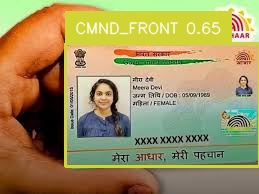

Number of detections: 1
Detection: CMND_FRONT, Confidence: 0.65, Coordinates: [     65.372      43.192         259      166.36]


In [ ]:
import cv2
import supervision as sv
from ultralytics import YOLO
import IPython

# Load the custom model
model_loaded = YOLO('/content/runs/detect/train/weights/best.pt')

# Specify the path to your single image
image_path = '/content/download (2).jpeg'  # Replace with your actual image path

# Load image
image = cv2.imread(image_path)

# Perform inference with labels
results = model_loaded(image, conf=0.50)[0]

# Create Detections with labels
detections = sv.Detections(
    xyxy=results.boxes.xyxy.cpu().numpy(),
    confidence=results.boxes.conf.cpu().numpy(),
    class_id=results.boxes.cls.cpu().numpy().astype(int)
)

# Get class names from the model
class_names = model_loaded.names

# Annotate boxes and labels with class names
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(
    text_scale=0.5,  # Adjust text size if needed
    text_thickness=1,  # Adjust text thickness  # You can customize color palette
)

# Annotate the image with detections and their labels
annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=[f"{class_names[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
)

# Display annotated image
_, buffer = cv2.imencode('.jpg', annotated_image)
i = IPython.display.Image(data=buffer)
IPython.display.display(i)

# Print detection details
print("Number of detections:", len(detections))
for box, conf, cls in zip(detections.xyxy, detections.confidence, detections.class_id):
    print(f"Detection: {class_names[cls]}, Confidence: {conf:.2f}, Coordinates: {box}")


0: 480x640 1 CMND_FRONT, 16.3ms
Speed: 2.5ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


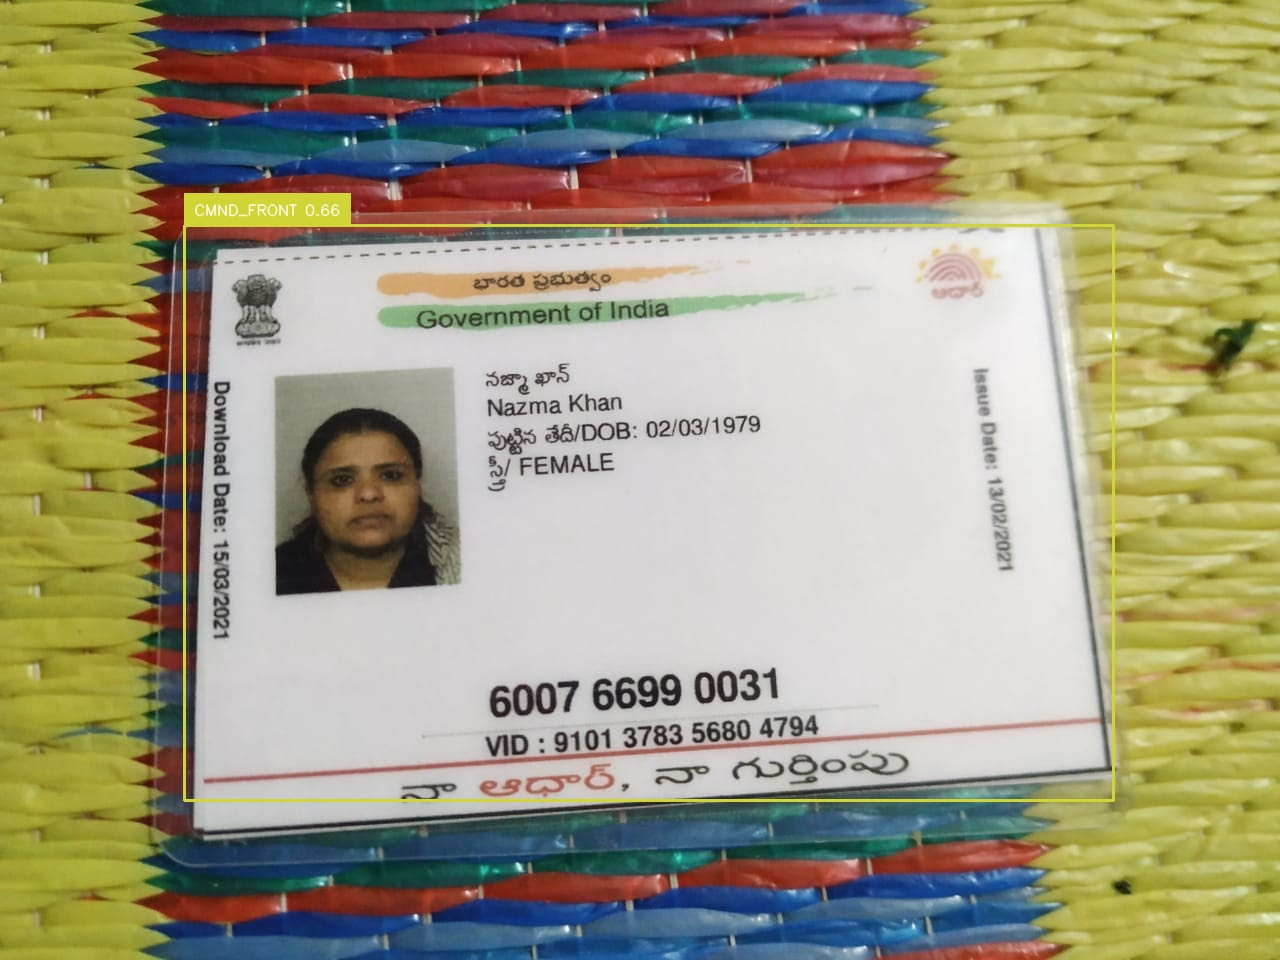

Number of detections: 1
Detection: CMND_FRONT, Confidence: 0.66, Coordinates: [      184.7       225.6      1113.1      800.84]


In [ ]:
import cv2
import supervision as sv
from ultralytics import YOLO
import IPython

# Load the custom model
model_loaded = YOLO('/content/runs/detect/train/weights/best.pt')

# Specify the path to your single image
image_path = '/content/thread-158126756-9617603376122831663.jpg'  # Replace with your actual image path

# Load image
image = cv2.imread(image_path)

# Perform inference with labels
results = model_loaded(image, conf=0.50)[0]

# Create Detections with labels
detections = sv.Detections(
    xyxy=results.boxes.xyxy.cpu().numpy(),
    confidence=results.boxes.conf.cpu().numpy(),
    class_id=results.boxes.cls.cpu().numpy().astype(int)
)

# Get class names from the model
class_names = model_loaded.names

# Annotate boxes and labels with class names
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(
    text_scale=0.5,  # Adjust text size if needed
    text_thickness=1,  # Adjust text thickness  # You can customize color palette
)

# Annotate the image with detections and their labels
annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=[f"{class_names[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
)

# Display annotated image
_, buffer = cv2.imencode('.jpg', annotated_image)
i = IPython.display.Image(data=buffer)
IPython.display.display(i)

# Print detection details
print("Number of detections:", len(detections))
for box, conf, cls in zip(detections.xyxy, detections.confidence, detections.class_id):
    print(f"Detection: {class_names[cls]}, Confidence: {conf:.2f}, Coordinates: {box}")